In [1]:
import numpy as np
import pandas as pd
import string
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings # supress warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)
import nltk
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
import re
import nltk

In [2]:
data = pd.read_json('train_spider.json') # load training set
df1 =data.head(2000) # we have taken the first 2000 records for training

df2 =pd.read_json('train_others.json') # load test set

In [3]:
df1.shape

(2000, 7)

In [4]:
df2.shape # 1659 for testing purpose

(1659, 7)

In [5]:
# 4.1 Punctuations Removal
import string

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

df1["clean_question"] = df1['question'].apply(remove_punctuations)

df2["clean_question"] = df2['question'].apply(remove_punctuations)

In [6]:
# 4.2 Whitespace Removal
df1['clean_query'] = df1['query'].str.strip(string.whitespace)
df1['clean_question'] = df1['clean_question'].str.strip(string.whitespace)

df2['clean_query'] = df2['query'].str.strip(string.whitespace)
df2['clean_question'] = df2['clean_question'].str.strip(string.whitespace)


In [7]:
# 4.3 Lowering the text
df1['query_lower']= df1['clean_query'].apply(lambda x: x.lower())
df1['quest_lower']= df1['clean_question'].apply(lambda x: x.lower())


df2['query_lower']= df2['clean_query'].apply(lambda x: x.lower())
df2['quest_lower']= df2['clean_question'].apply(lambda x: x.lower())

In [8]:
df1.head()

,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql,clean_question,clean_query,query_lower,quest_lower
0,department_management,SELECT count(*) FROM head WHERE age > 56,"[SELECT, count, (, *, ), FROM, head, WHERE, age, >, 56]","[select, count, (, *, ), from, head, where, age, >, value]",How many heads of the departments are older than 56 ?,"[How, many, heads, of, the, departments, are, older, than, 56, ?]","{'from': {'table_units': [['table_unit', 1]], 'conds': []}, 'select': [False, [[3, [0, [0, 0, False], None]]]], 'where': [[False, 3, [0, [0, 10, False], None], 56.0, None]], 'groupBy': [], 'having': [], 'orderBy': [], 'limit': None, 'intersect': None, 'union': None, 'except': None}",How many heads of the departments are older than 56,SELECT count(*) FROM head WHERE age > 56,select count(*) from head where age > 56,how many heads of the departments are older than 56
1,department_management,"SELECT name , born_state , age FROM head ORDER BY age","[SELECT, name, ,, born_state, ,, age, FROM, head, ORDER, BY, age]","[select, name, ,, born_state, ,, age, from, head, order, by, age]","List the name, born state and age of the heads of departments ordered by age.","[List, the, name, ,, born, state, and, age, of, the, heads, of, departments, ordered, by, age, .]","{'from': {'table_units': [['table_unit', 1]], 'conds': []}, 'select': [False, [[0, [0, [0, 8, False], None]], [0, [0, [0, 9, False], None]], [0, [0, [0, 10, False], None]]]], 'where': [], 'groupBy': [], 'having': [], 'orderBy': ['asc', [[0, [0, 10, False], None]]], 'limit': None, 'intersect': None, 'union': None, 'except': None}",List the name born state and age of the heads of departments ordered by age,"SELECT name , born_state , age FROM head ORDER BY age","select name , born_state , age from head order by age",list the name born state and age of the heads of departments ordered by age
2,department_management,"SELECT creation , name , budget_in_billions FROM department","[SELECT, creation, ,, name, ,, budget_in_billions, FROM, department]","[select, creation, ,, name, ,, budget_in_billions, from, department]","List the creation year, name and budget of each department.","[List, the, creation, year, ,, name, and, budget, of, each, department, .]","{'from': {'table_units': [['table_unit', 0]], 'conds': []}, 'select': [False, [[0, [0, [0, 3, False], None]], [0, [0, [0, 2, False], None]], [0, [0, [0, 5, False], None]]]], 'where': [], 'groupBy': [], 'having': [], 'orderBy': [], 'limit': None, 'intersect': None, 'union': None, 'except': None}",List the creation year name and budget of each department,"SELECT creation , name , budget_in_billions FROM department","select creation , name , budget_in_billions from department",list the creation year name and budget of each department
3,department_management,"SELECT max(budget_in_billions) , min(budget_in_billions) FROM department","[SELECT, max, (, budget_in_billions, ), ,, min, (, budget_in_billions, ), FROM, department]","[select, max, (, budget_in_billions, ), ,, min, (, budget_in_billions, ), from, department]",What are the maximum and minimum budget of the departments?,"[What, are, the, maximum, and, minimum, budget, of, the, departments, ?]","{'from': {'table_units': [['table_unit', 0]], 'conds': []}, 'select': [False, [[1, [0, [0, 5, False], None]], [2, [0, [0, 5, False], None]]]], 'where': [], 'groupBy': [], 'having': [], 'orderBy': [], 'limit': None, 'intersect': None, 'union': None, 'except': None}",What are the maximum and minimum budget of the departments,"SELECT max(budget_in_billions) , min(budget_in_billions) FROM department","select max(budget_in_billions) , min(budget_in_billions) from department",what are the maximum and minimum budget of the departments
4,department_management,SELECT avg(num_employees) FROM department WHERE ranking BETWEEN 10 AND 15,"[SELECT, avg, (, num_employees, ), FROM, department, WHERE, ranking, BETWEEN, 10, AND, 15]","[select, avg, (, num_employees, ), from, department, w

In [9]:
# Final pre-processed data with tokenised query and lemmatised question column
df1.columns

Index(['db_id', 'query', 'query_toks', 'query_toks_no_value', 'question', 'question_toks', 'sql', 'clean_question', 'clean_query', 'query_lower', 'quest_lower'], dtype='object')

In [10]:
selected_columns_1 = df1[["query_lower","quest_lower"]]

selected_columns_2 = df2[["query_lower","quest_lower"]]

In [11]:
df_train = selected_columns_1.copy()

df_test = selected_columns_2.copy()

In [12]:
df_train.head()

,query_lower,quest_lower
0,select count(*) from head where age > 56,how many heads of the departments are older than 56
1,"select name , born_state , age from head order by age",list the name born state and age of the heads of departments ordered by age
2,"select creation , name , budget_in_billions from department",list the creation year name and budget of each department
3,"select max(budget_in_billions) , min(budget_in_billions) from department",what are the maximum and minimum budget of the departments
4,select avg(num_employees) from department where ranking between 10 and 15,what is the average number of employees of the departments whose rank is between 10 and 15


In [13]:
# For Train
input_sentences = df_train['quest_lower']
output_sentences = df_train['query_lower'].astype(str) + ' <eos>'
output_sentences_inputs = '<sos> ' + df_train['query_lower'].astype(str)


# For Test

input_test_sentences = df_test['quest_lower']
output_test_sentences = df_test['query_lower'].astype(str) + ' <eos>'
output_test_sentences_inputs = '<sos> ' + df_test['query_lower'].astype(str)

In [14]:
print("num samples input training:", len(input_sentences))
print("num samples output training :", len(output_sentences))
print("num samples output input training :", len(output_sentences_inputs))


print("num samples input test :", len(input_test_sentences))
print("num samples output test :", len(output_test_sentences))
print("num samples output input test :", len(output_test_sentences_inputs))


num samples input training: 2000
num samples output training : 2000
num samples output input training : 2000
num samples input test : 1659
num samples output test : 1659
num samples output input test : 1659


In [15]:
print(input_sentences[172])
print(output_sentences[172])
print(output_sentences_inputs[172])

print(input_test_sentences[172])
print(output_test_sentences[172])
print(output_test_sentences_inputs[172])

what are the names of all stations that have more than 10 bikes available and are not located in san jose
select t1.name from station as t1 join status as t2 on t1.id  =  t2.station_id group by t2.station_id having avg(bikes_available)  >  10 except select name from station where city  =  "san jose" <eos>
<sos> select t1.name from station as t1 join status as t2 on t1.id  =  t2.station_id group by t2.station_id having avg(bikes_available)  >  10 except select name from station where city  =  "san jose"
what state has the city with the most population
select state_name from city where population  =  ( select max ( population ) from city ); <eos>
<sos> select state_name from city where population  =  ( select max ( population ) from city );


TOKENIZATION

In [16]:
max_features = 20000 # this is the number of words we care about

# For Training
input_tokenizer = Tokenizer(num_words=max_features,split = ' ', oov_token='<unw>',filters='')
input_tokenizer.fit_on_texts(input_sentences)

# this takes our sentences and replaces each word with an integer
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)


word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input train set : %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input train set: %g" % max_input_len)

# For Testing

input_test_tokenizer = Tokenizer(num_words=max_features,split = ' ', oov_token='<unw>',filters='')
input_test_tokenizer.fit_on_texts(input_test_sentences)

# this takes our sentences and replaces each word with an integer
input_test_integer_seq = input_test_tokenizer.texts_to_sequences(input_test_sentences)


word2idx_test_inputs = input_test_tokenizer.word_index
print('Total unique words in the input test set : %s' % len(word2idx_test_inputs))

max_input_test_len = max(len(sen) for sen in input_test_integer_seq)
print("Length of longest sentence in input test set : %g" % max_input_test_len)


Total unique words in the input train set : 1422
Length of longest sentence in input train set: 37
Total unique words in the input test set : 878
Length of longest sentence in input test set : 22


In [17]:
# For Training
output_tokenizer = Tokenizer(num_words=max_features, oov_token='<unw>', split = ' ',filters='')
output_tokenizer.fit_on_texts(output_sentences_inputs + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

# For Testing

output_test_tokenizer = Tokenizer(num_words=max_features, oov_token='<unw>', split = ' ',filters='')
output_test_tokenizer.fit_on_texts(output_test_sentences_inputs + output_test_sentences)
output_test_integer_seq = output_test_tokenizer.texts_to_sequences(output_test_sentences)
output_test_input_integer_seq = output_test_tokenizer.texts_to_sequences(output_test_sentences_inputs)

word2idx_test_outputs = output_test_tokenizer.word_index
print('Total unique words in the output in test set : %s' % len(word2idx_test_outputs))

num_test_words_output = len(word2idx_test_outputs) + 1
max_test_out_len = max(len(sen) for sen in output_test_integer_seq)
print("Length of longest sentence in the output in test set: %g" % max_test_out_len)

Total unique words in the output: 2316
Length of longest sentence in the output: 58
Total unique words in the output in test set : 1247
Length of longest sentence in the output in test set: 77


`PADDING

In [18]:
# For training set
sequence_length_input = 37
sequence_length_output = 58

# For Test Set

sequence_length_input_test = 22
sequence_length_output_test = 77

In [19]:
# we then pad the sequences so they're all the same length (sequence_length)
# For Training
encoder_input_sequences = pad_sequences(input_integer_seq, sequence_length_input )
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[172]:", encoder_input_sequences[172])

# we then pad the sequences so they're all the same length (sequence_length)
decoder_input_sequences = pad_sequences(output_input_integer_seq, sequence_length_output, padding='post' )

print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[172]:", decoder_input_sequences[172])

#  For Testing
encoder_test_input_sequences = pad_sequences(input_test_integer_seq, sequence_length_input_test )
print("encoder_test_input_sequences.shape:", encoder_test_input_sequences.shape)
print("encoder_test_input_sequences[172]:", encoder_test_input_sequences[172])

# we then pad the sequences so they're all the same length (sequence_length)
decoder_test_input_sequences = pad_sequences(output_test_input_integer_seq, sequence_length_output_test, padding='post' )

print("decoder_test_input_sequences.shape:", decoder_test_input_sequences.shape)
print("decoder_test_input_sequences[172]:", decoder_test_input_sequences[172])

encoder_input_sequences.shape: (2000, 37)
encoder_input_sequences[172]: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   5   6
   2   7   3  12  94  14  15  34  22 117 271 256   4   6  35 270   8 355
 558]
decoder_input_sequences.shape: (2000, 58)
decoder_input_sequences[172]: [  7   5  22   2  57   3  13  10  88   3  14  11  23   4 235  16   9 235
  29 427  20 275  49   5  21   2  57   6  47   4 335 892   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]
encoder_test_input_sequences.shape: (1659, 22)
encoder_test_input_sequences[172]: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  4 11 18  2 45 17  2 21 28]
decoder_test_input_sequences.shape: (1659, 77)
decoder_test_input_sequences[172]: [14  9 20  6 41  7 31  2  8  9 37  8 31 12  6 41 55  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]

In [20]:
# we then pad the sequences so they're all the same length (sequence_length)
# For Training
decoder_output_sequences = pad_sequences(output_integer_seq, sequence_length_output, padding='post' )

print("decoder_output_sequences.shape:", decoder_output_sequences.shape)
print("decoder_output_sequences[172]:", decoder_output_sequences[172])

# For testing

decoder_test_output_sequences = pad_sequences(output_test_integer_seq, sequence_length_output_test, padding='post' )

print("decoder_test_output_sequences.shape:", decoder_test_output_sequences.shape)
print("decoder_test_output_sequences[172]:", decoder_test_output_sequences[172])

decoder_output_sequences.shape: (2000, 58)
decoder_output_sequences[172]: [  5  22   2  57   3  13  10  88   3  14  11  23   4 235  16   9 235  29
 427  20 275  49   5  21   2  57   6  47   4 335 892   8   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]
decoder_test_output_sequences.shape: (1659, 77)
decoder_test_output_sequences[172]: [ 9 20  6 41  7 31  2  8  9 37  8 31 12  6 41 55 15  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0]


WORD EMBEDDINGS USING GLOVE

In [21]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open(r'C:/Users/naina/Music/glove.6B/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [22]:
EMBEDDING_SIZE = 100
# For training input
num_words = min(max_features, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

        
# For test input set 

num_test_words = min(max_features, len(word2idx_test_inputs) + 1)
embedding_test_matrix = zeros((num_test_words, EMBEDDING_SIZE))
for word, index in word2idx_test_inputs.items():
    embedding_test_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_test_matrix[index] = embedding_test_vector

In [23]:
# For training set
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

# For Testing set 
embedding_test_layer = Embedding(num_test_words, EMBEDDING_SIZE, weights=[embedding_test_matrix], input_length=max_input_test_len)

In [24]:
# For training set 
# to create empty output array,for decoder model
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)

# For testing set

decoder_targets_test_one_hot = np.zeros((
        len(input_test_sentences),
        max_test_out_len,
        num_test_words_output
    ),
    dtype='float32'
)

In [25]:
print(decoder_targets_one_hot.shape)

print(decoder_targets_test_one_hot.shape)

(2000, 58, 2317)
(1659, 77, 1248)


In [26]:
num_test_words_output

1248

In [27]:
# For training set 
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1


In [28]:

# For testing set 

for i, d in enumerate(decoder_test_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_test_one_hot[i, t, word] = 1

In [29]:
decoder_test_output_sequences.shape

(1659, 77)

In [30]:
decoder_output_sequences.shape

(2000, 58)

Defining Encoder

In [31]:
LSTM_NODES =256

In [32]:
# For training set
encoder_inputs_placeholder = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(units=LSTM_NODES, return_sequences=True, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

Defining Decoder

In [33]:
# Now create the Decoder layers.
decoder_inputs_placeholder = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)
decoder_d1 = Dense(LSTM_NODES, activation="relu")
decoder_d2 = Dense(num_words_output, activation='softmax')
# Drop-out is added in the dense layers to help mitigate overfitting in this part of the model.
decoder_outputs = decoder_d2(Dropout(rate=.4)(decoder_d1(Dropout(rate=.4)(decoder_outputs))))

In [34]:
model = Model([encoder_inputs_placeholder,
  decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
# Training the model

BATCH_SIZE = 64
EPOCHS = 30

history = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
)

Epoch 1/20
25/25 [==============================] - 11s 353ms/step - loss: 2.3125 - accuracy: 0.7217 - val_loss: 1.5890 - val_accuracy: 0.7493
Epoch 2/20
25/25 [==============================] - 7s 294ms/step - loss: 1.2959 - accuracy: 0.7686 - val_loss: 1.4986 - val_accuracy: 0.7576
Epoch 3/20
25/25 [==============================] - 7s 291ms/step - loss: 1.1707 - accuracy: 0.7815 - val_loss: 1.4305 - val_accuracy: 0.7795
Epoch 4/20
25/25 [==============================] - 8s 324ms/step - loss: 1.0287 - accuracy: 0.8015 - val_loss: 1.3004 - val_accuracy: 0.8153
Epoch 5/20
25/25 [==============================] - 8s 318ms/step - loss: 0.8794 - accuracy: 0.8303 - val_loss: 1.2165 - val_accuracy: 0.8355
Epoch 6/20
25/25 [==============================] - 8s 328ms/step - loss: 0.7740 - accuracy: 0.8496 - val_loss: 1.2484 - val_accuracy: 0.8394
Epoch 7/20
25/25 [==============================] - 8s 339ms/step - loss: 0.7018 - accuracy: 0.8616 - val_loss: 1.2538 - val_accuracy: 0.8513
Epoch

In [167]:
print("Average train accuracy: ", np.average(history.history['accuracy']))
print("Average train loss: ", np.average(history.history['loss']))
print("Average val accuracy: ", np.average(history.history['val_accuracy']))
print("Average val loss: ", np.average(history.history['val_loss']))

Average train accuracy:  0.8548706889152526
Average train loss:  0.7548061177134514
Average val accuracy:  0.8408620715141296
Average val loss:  1.3977965831756591


In [36]:
import matplotlib.pyplot as plt 

def plot_hist_classif(hist):
  n_ = len(hist.history['accuracy'])
  plt.plot(range(1, n_+1), 100*np.asarray(hist.history['accuracy']), 'bo', label='Accuracy on training set')
  plt.plot(range(1, n_+1), 100*np.asarray(hist.history['val_accuracy']), 'b', label='Accuracy on validation set')
  plt.legend()
  plt.xlabel("Epoch") 
  plt.ylabel("Accuracy")
  plt.ylim(0, 100)
  plt.axhline(y=50)
  plt.show()

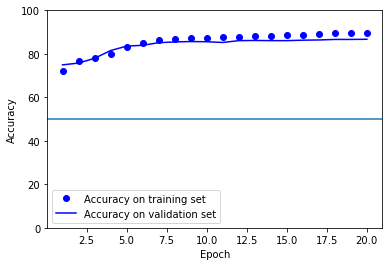

In [37]:
plot_hist_classif(history)

In [164]:
def plot_his_loss(hist):
  n_ = len(hist.history['loss'])
  plt.plot(range(1, n_+1), 100*np.asarray(hist.history['loss']), 'bo', label='Loss on training set')
  plt.plot(range(1, n_+1), 100*np.asarray(hist.history['val_loss']), 'b', label='Loss on validation set')
  plt.legend()
  plt.xlabel("Epoch") 
  plt.ylabel("Loss")
  plt.ylim(0, 100)
  plt.axhline(y=50)
  plt.show()

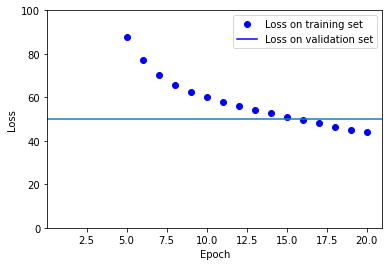

In [165]:
plot_his_loss(history)

# For Prediction

In [38]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

In [39]:
# Each step we need the decoder hidden and cell states, we will modify our model to accept the hidden and cell states as shown below:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

decoder_states = [h, c]
decoder_outputs = decoder_d2(Dropout(rate=.4)(decoder_d1(Dropout(rate=.4)(decoder_outputs))))

In [40]:
# Updating the decoder Model
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

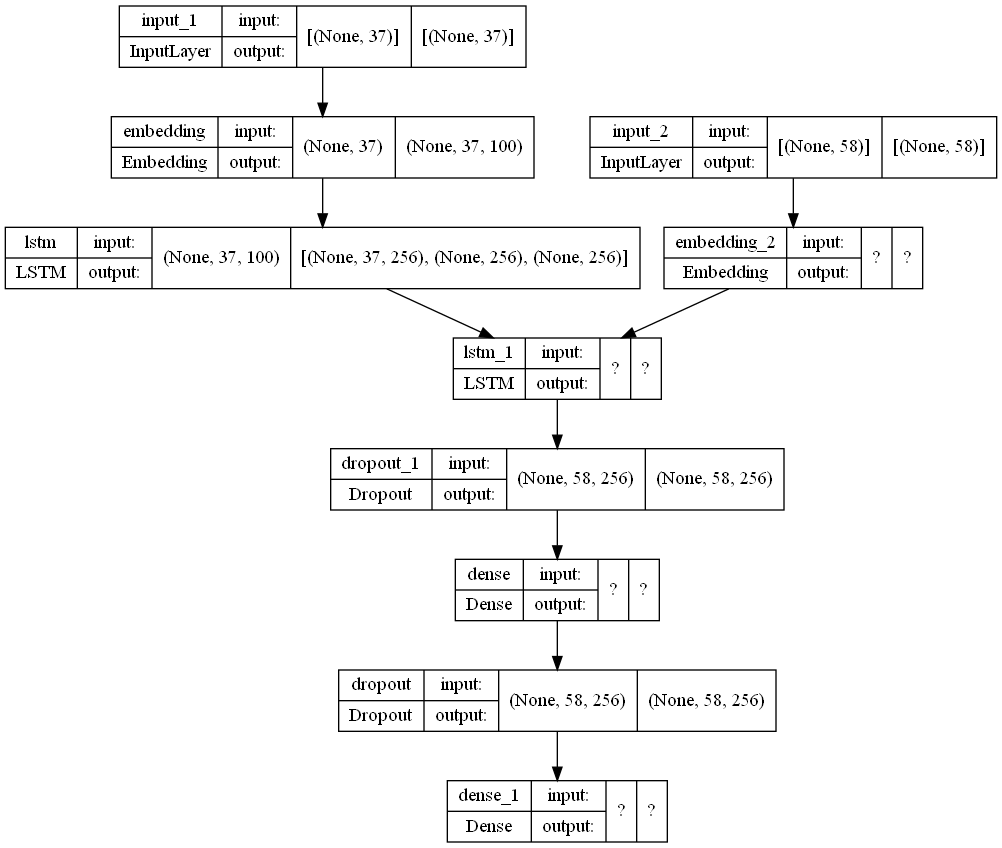

In [41]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [44]:
# To get the words for the output prediction

idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [45]:
# Customised Translation function
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

  #  return ' '.join(output_sentence)
    return output_sentence

Test Predictions

In [175]:
j = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[j:j+1]
translation_train = translate_sentence(input_seq)
print('-')
print('Input from train set :', input_sentences[j])
print('Response:', translation_train)


true_train_output = df1.iloc[j]['query_lower']

print('BLEU-1: %f' % nltk.translate.bleu_score.sentence_bleu(true_train_output, translation_train, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % nltk.translate.bleu_score.sentence_bleu(true_train_output, translation_train, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % nltk.translate.bleu_score.sentence_bleu(true_train_output, translation_train, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % nltk.translate.bleu_score.sentence_bleu(true_train_output, translation_train, weights=(0.25, 0.25, 0.25, 0.25)))

-
Input from train set : find number of tracks in each genre
Response: ['select', 'count(*)', 'from', 'genre', 'as', 't1', 'join', 'track', 'as', 't2', 'on', 't1.genreid', '=', 't2.genreid', 'where', 't1.name', '=', '"pop"']
BLEU-1: 0.055556
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000


In [89]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input from training set :', input_sentences[i])
print('Response:', translation)

-
Input from training set : list the hardware model name for the phons that were produced by nokia corporation but whose screen mode type is not text
Response: ['select', 'distinct', 't2.hardware_model_name', 'from', 'screen_mode', 'as', 't1', 'join', 'phone', 'as', 't2', 'on', 't1.graphics_mode', '=', 't2.screen_mode', 'where', 't2.company_name', '=', '"nokia', 'corporation";']


In [171]:
i = np.random.choice(len(input_test_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input from test set :', input_test_sentences[i])
print('Response:', translation)

-
Input from test set : what is the nationality of the actress  christoph waltz
Response: ['select', 'nominee', 'from', 'musical', 'where', 'award', '=', '"tony', 'award"', 'intersect', 'select', 'course_id', 'from', 'section', 'where', 'semester', '=', "'spring'", 'and', 'year', '=', '2010']


In [174]:
i = np.random.choice(len(input_test_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('-')
print('Input from test set :', input_test_sentences[i])
print('Response:', translation)



true_test_output = df2.iloc[j]['query_lower']

print('BLEU-1: %f' % nltk.translate.bleu_score.sentence_bleu(true_test_output, translation_train, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % nltk.translate.bleu_score.sentence_bleu(true_test_output, translation_train, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % nltk.translate.bleu_score.sentence_bleu(true_test_output, translation_train, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % nltk.translate.bleu_score.sentence_bleu(true_test_output, translation_train, weights=(0.25, 0.25, 0.25, 0.25)))


-
Input from test set : find all users who have written tips for  barrio cafe  in 2015
Response: ['select', 'birth_place', ',', 'count(*)', 'from', 'people', 'group', 'by', 'party', 'order', 'by', 'count(*)', 'desc', 'limit', '1']
BLEU-1: 0.076923
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000
